In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d_backward", base_dir, sample_rate=1.0)
X.info()

< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found
< 0 found


/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:252: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443475 entries, 0 to 443474
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             443475 non-null  int64  
 1   in_channels   443475 non-null  int64  
 2   iH            443475 non-null  int64  
 3   iW            443475 non-null  int64  
 4   out_channels  443475 non-null  int64  
 5   groups        443475 non-null  int64  
 6   kH            443475 non-null  int64  
 7   kW            443475 non-null  int64  
 8   stride        443475 non-null  int64  
 9   dilation      443475 non-null  int64  
 10  gflops        443475 non-null  float64
 11  dtype_16      443475 non-null  bool   
 12  dtype_32      443475 non-null  bool   
 13  dtype_b16     443475 non-null  bool   
 14  transposed_0  443475 non-null  bool   
 15  transposed_1  443475 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 39.3 MB


In [3]:
df = pd.concat([X, y], axis=1)
df = df.query("time > 0").dropna()
X, y = df.drop(["time"], axis=1), df["time"]

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310130 entries, 164121 to 121958
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             310130 non-null  int64  
 1   in_channels   310130 non-null  int64  
 2   iH            310130 non-null  int64  
 3   iW            310130 non-null  int64  
 4   out_channels  310130 non-null  int64  
 5   groups        310130 non-null  int64  
 6   kH            310130 non-null  int64  
 7   kW            310130 non-null  int64  
 8   stride        310130 non-null  int64  
 9   dilation      310130 non-null  int64  
 10  gflops        310130 non-null  float64
 11  dtype_16      310130 non-null  bool   
 12  dtype_32      310130 non-null  bool   
 13  dtype_b16     310130 non-null  bool   
 14  transposed_0  310130 non-null  bool   
 15  transposed_1  310130 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 29.9 MB


# Fitting

## Decision Tree

Train--------
Mean Squared Error: 311.04023551895847
MAPE: 0.036897385009638066
R-squared: 0.9981921942194677


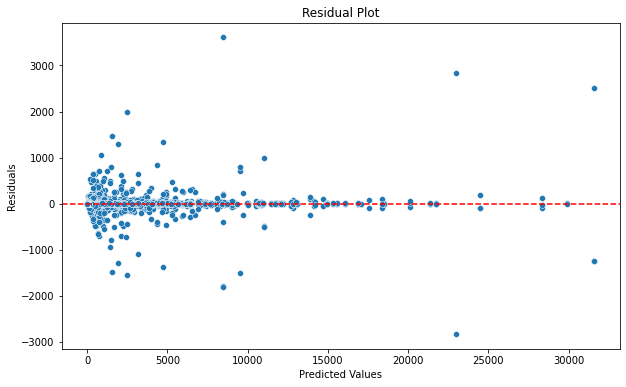

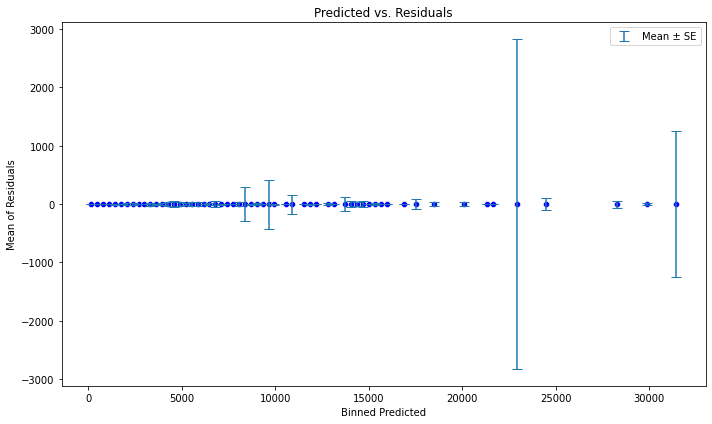

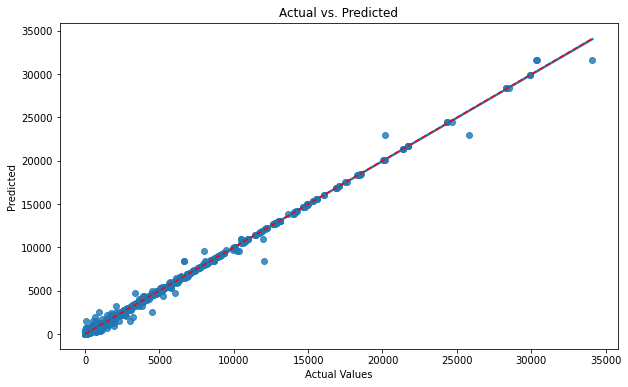

Val--------
Mean Squared Error: 2704.1124057704783
MAPE: 0.1207308975285567
R-squared: 0.9863393713326554


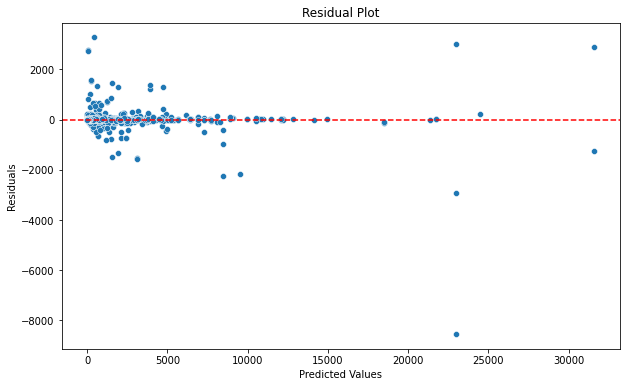

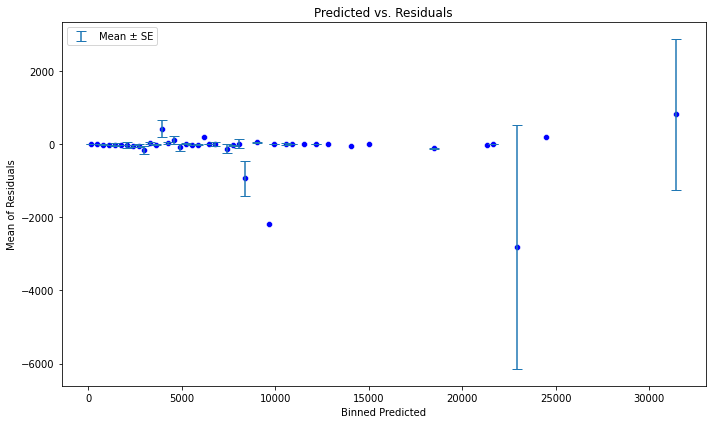

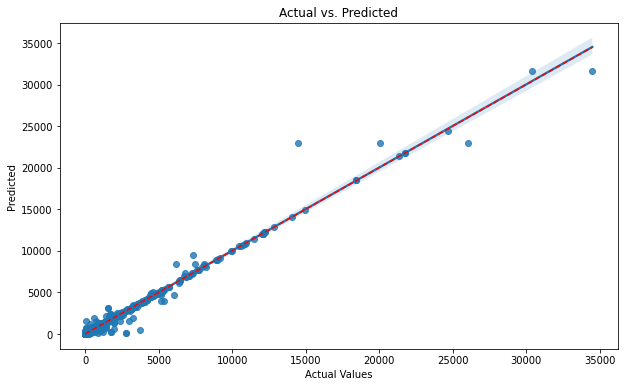

In [5]:
tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

y_train_res = y_hat_train - y_train

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [6]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})


features_df = features_df.sort_values(by='Importance', ascending=False)
features_df

,Feature,Importance
5,groups,0.580314
10,gflops,0.365097
12,dtype_32,0.031703
0,b,0.006425
1,in_channels,0.004313
15,transposed_1,0.002409
4,out_channels,0.002253
2,iH,0.002105
3,iW,0.001682
7,kW,0.001567


## Regression Forest

Train--------
Mean Squared Error: 154.75834777420155
MAPE: 0.06944904372731468
R-squared: 0.9991005246146852


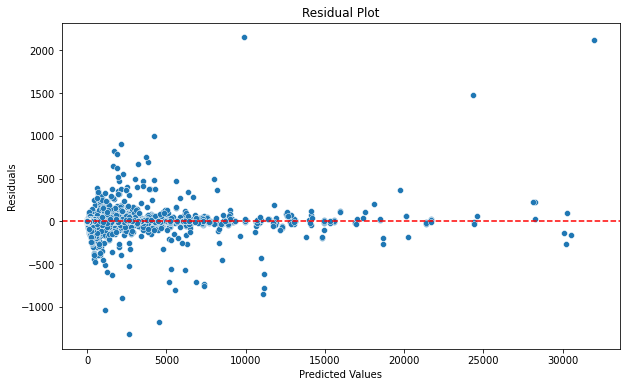

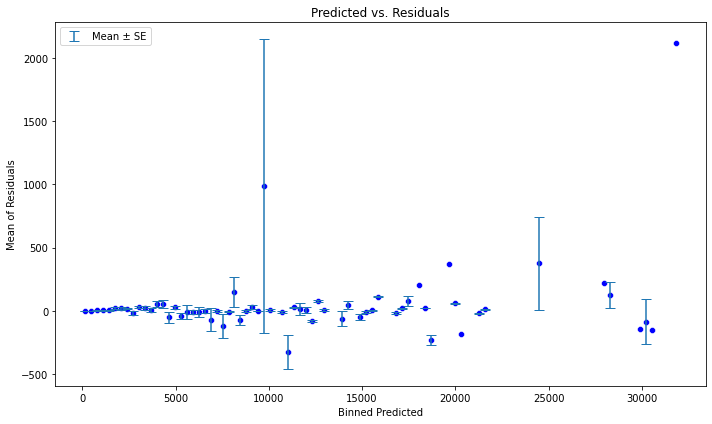

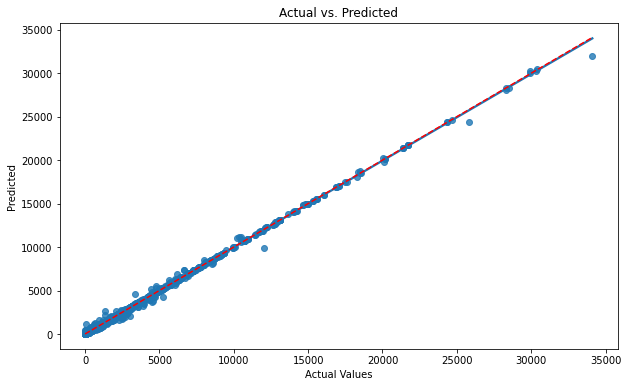

Val--------
Mean Squared Error: 1624.6741409489543
MAPE: 0.13434994924090982
R-squared: 0.9917924750104399


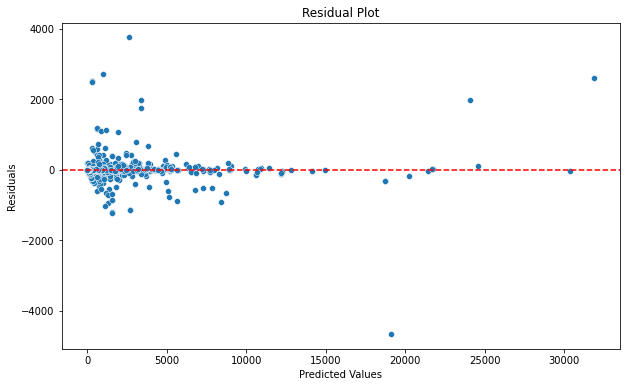

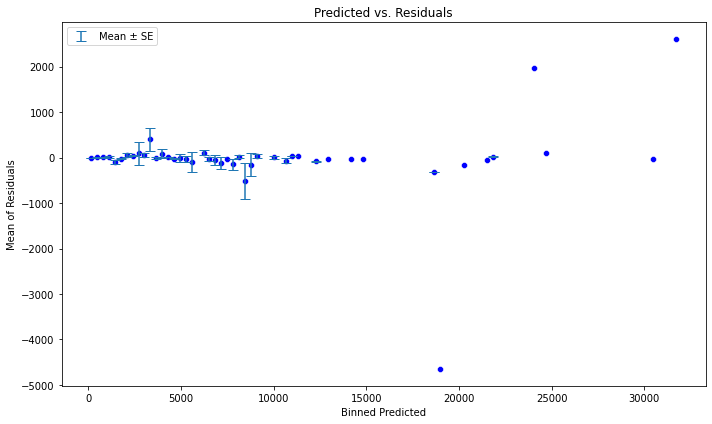

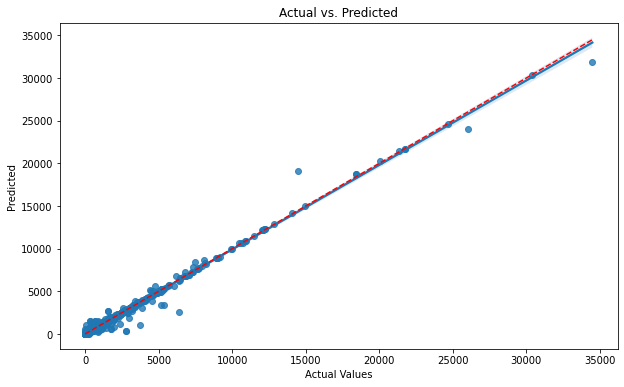

In [8]:
tree_model = RandomForestRegressor(n_estimators=30, max_depth=25, random_state=random_seed)
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [9]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
)

features_df = features_df.sort_values(by="Importance", ascending=False)
features_df

,Feature,Importance
5,groups,0.568102
10,gflops,0.374938
12,dtype_32,0.030909
0,b,0.006816
1,in_channels,0.004156
4,out_channels,0.003486
2,iH,0.002589
3,iW,0.002384
7,kW,0.002118
6,kH,0.001727
